In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf


In [2]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import TextVectorization


In [3]:
print(tf.__version__)

2.7.0


To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

At the top of your notebook, update the code that downloads the IMDB dataset with code to download the Stack Overflow dataset that has been prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

Modify the last layer of your model to read Dense(4), as there are now four output classes.

When compiling the model, change the loss to tf.keras.losses.SparseCategoricalCrossentropy. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, 1, 2, or 3). In addition, change the metrics to metrics=['accuracy'], since this is a multi-class classification problem (tf.metrics.BinaryAccuracy is only used for binary classifiers).

When plotting accuracy over time, change binary_accuracy and val_binary_accuracy to accuracy and val_accuracy, respectively.

Once these changes are complete, you will be able to train a multi-class classifier.



# Download Stackoverflow dataset

In [4]:
ds_dir="datasets/stack_overflow/"
os.makedirs(ds_dir)
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset = tf.keras.utils.get_file("stack_overflow_16k",url,untar=True, cache_dir=ds_dir, cache_subdir='')
dataset_dir  = os.path.join(os.path.dirname(dataset),'stack_overflow')

6062080/6053168 [==============================] - 1s 0us/step


In [5]:
print (os.path.dirname(dataset))

datasets/stack_overflow


In [6]:
dataset_dir = os.path.dirname(dataset)

In [7]:
os.listdir(dataset_dir)

['test', 'README.md', 'train', 'stack_overflow_16k.tar.gz']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'python', 'javascript']

In [9]:
sample_file = os.path.join(train_dir, 'python/1655.txt')
with open(sample_file) as f:
  print(f.read())


"program runs in pycharm but will not run in the console this is my first programming language class, so please be patient. the program runs fine in pycharm. but when i try to run the program in c:windowspy.exe it will populate the first question of my program. when i answer the question it closes suddenly. ..pounds = float(input('please enter the value of pounds you wish to convert to kilograms: ')).kilograms = pounds * 0.45359237.print(""the conversion to kilograms is: "", format(kilograms, '.2f'))"



# load the dataset

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    ds_dir+'/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2021-09-10 09:11:59.939915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47220 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:67:00.0, compute capability: 7.5
2021-09-10 09:11:59.941353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46840 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:68:00.0, compute capability: 7.5


In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [13]:
# now validation set

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    ds_dir+ 'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [14]:
# now test set
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    ds_dir+'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


# preprocessing

To deal with programming language, we need to process the puctuation. we will try two different versions of preprocess to test this idea. 

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return stripped_html
  #return tf.strings.regex_replace(stripped_html,
  #                                '[%s]' % re.escape(string.punctuation),
  #                                '')

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

raw_train_ds is in a form of tf.data.Dataset

> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3]) \
> dataset = dataset.map(lambda x: x*2) \
> list(dataset.as_numpy_iterator()) \
> [2, 4, 6]

In [17]:
# Make a text-only dataset (without labels), then call adapt
# If desired, the user can call this layer's adapt() method on a dataset. When this layer is adapted,
# it will analyze the dataset, determine the frequency of individual string values,
# and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped,
# depending on the configuration options for this layer; if there are more unique values
# in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  direction
 313 --->  instead
Vocabulary size: 10000


In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# model 

In [22]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (G  (None, 16)                0         
lobalAveragePooling1D)                                           
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
_________________________________________________________________
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])


In [24]:
#epochs = 30
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
200/200 [==============================] - 2s 6ms/step - loss: 1.3785 - accuracy: 0.3309 - val_loss: 1.3663 - val_accuracy: 0.3963
Epoch 2/50
200/200 [==============================] - 1s 5ms/step - loss: 1.3495 - accuracy: 0.4652 - val_loss: 1.3276 - val_accuracy: 0.5125
Epoch 3/50
200/200 [==============================] - 1s 5ms/step - loss: 1.2991 - accuracy: 0.5145 - val_loss: 1.2685 - val_accuracy: 0.5638
Epoch 4/50
200/200 [==============================] - 1s 5ms/step - loss: 1.2295 - accuracy: 0.5698 - val_loss: 1.1964 - val_accuracy: 0.6144
Epoch 5/50
200/200 [==============================] - 1s 5ms/step - loss: 1.1530 - accuracy: 0.6266 - val_loss: 1.1221 - val_accuracy: 0.6700
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 1.0756 - accuracy: 0.6764 - val_loss: 1.0504 - val_accuracy: 0.7044
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 1.0032 - accuracy: 0.7138 - val_loss: 0.9851 - val_accuracy: 0.7294
Epoch 

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 3ms/step - loss: 0.5208 - accuracy: 0.8006
Loss:  0.5208292603492737
Accuracy:  0.8006250262260437


In [26]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

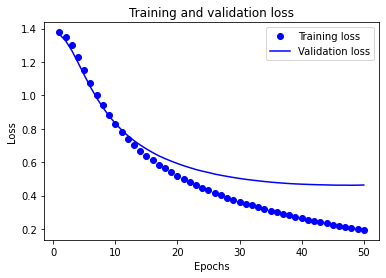

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

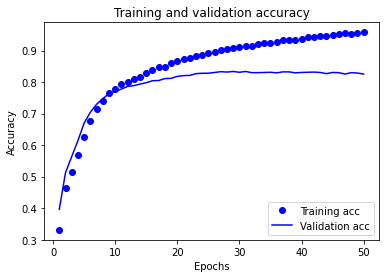

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.5208 - accuracy: 0.8006
0.8006250262260437


# strip all the punctuation (30 epoch 

250/250 [==============================] - 2s 6ms/step - loss: 0.5595 - accuracy: 0.7979
0.7978749871253967

# remaining all the punctuation 

250/250 [==============================] - 1s 5ms/step - loss: 0.5208 - accuracy: 0.8006
0.8006250262260437

In [30]:
examples = [
  "Csharp",
  "virtual machine, java package",
  "Javascript often abbreviated as JS, is a programming language that conforms to the ECMAScript specification",
  "Python is a great script language!!"]

export_model.predict(examples)

array([[0.29829714, 0.2518515 , 0.31187907, 0.13797228],
       [0.21435972, 0.2011904 , 0.3480053 , 0.23644458],
       [0.45941448, 0.2026607 , 0.21134934, 0.12657547],
       [0.2169258 , 0.16466887, 0.46212018, 0.15628514]], dtype=float32)

# stackoverflow!!!